In [1]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential 
from keras.layers import Dense, LSTM  # importing layers package , Dense layer is used to connect all layers
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 

In [2]:
dataset5 = web.DataReader('ITC.NS', data_source='yahoo',start='2015-08-30',end='2022-10-06')
dataset5

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-08-31,219.000000,214.399994,216.500000,216.766663,9634683.0,176.501251
2015-09-01,215.933334,209.533340,215.000000,210.300003,9470865.0,171.235794
2015-09-02,215.366669,210.100006,212.600006,213.399994,13014679.0,173.759964
2015-09-03,216.466660,212.733337,212.899994,213.333328,10088448.0,173.705658
2015-09-04,214.333328,209.833328,213.333328,211.399994,15716596.0,172.131439
...,...,...,...,...,...,...
2022-09-29,334.899994,327.750000,329.000000,333.049988,18281337.0,333.049988
2022-09-30,335.750000,330.149994,333.049988,332.200012,12427919.0,332.200012
2022-10-03,333.000000,323.250000,332.899994,324.399994,9111289.0,324.399994


In [3]:
len(dataset5)

1752

In [5]:
dataset5.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2022-09-29,334.899994,327.750000,329.000000,333.049988,18281337.0,333.049988
2022-09-30,335.750000,330.149994,333.049988,332.200012,12427919.0,332.200012
2022-10-03,333.000000,323.250000,332.899994,324.399994,9111289.0,324.399994
2022-10-04,334.000000,328.000000,328.700012,332.850006,8803255.0,332.850006
2022-10-06,339.299988,332.549988,335.000000,336.649994,22233686.0,336.649994


In [6]:
opn=dataset5[['Open']]

<AxesSubplot:xlabel='Date'>

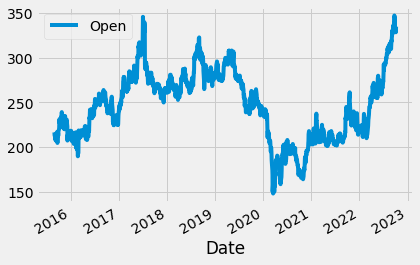

In [7]:
opn.plot()

In [8]:
ds=opn.values

In [9]:
ds

array([[216.5       ],
       [215.        ],
       [212.6000061 ],
       ...,
       [332.8999939 ],
       [328.70001221],
       [335.        ]])

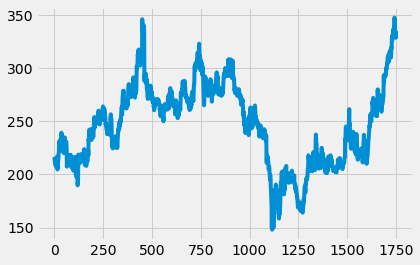

In [10]:
plt.plot(ds)

In [11]:
normalizer=MinMaxScaler(feature_range=(0,1))
ds_scaled=normalizer.fit_transform(np.array(ds).reshape(-1,1))

In [12]:
len(ds_scaled),len(ds)

(1752, 1752)

In [13]:
train_size=int(len(ds_scaled)*0.70)
test_size=len(ds_scaled)-train_size

In [14]:
train_size,test_size

(1226, 526)

In [15]:
ds_train,ds_test=ds_scaled[0:train_size,:],ds_scaled[train_size:len(ds_scaled),:1]

In [16]:
len(ds_train),len(ds_test)

(1226, 526)

In [17]:
#creating dataset in time series for LSTM model 
#X[100,120,140,160,180] : Y[200]
def create_ds(dataset,step):
    Xtrain, Ytrain = [], []
    for i in range(len(dataset)-step-1):
        a = dataset[i:(i+step), 0]
        Xtrain.append(a)
        Ytrain.append(dataset[i + step, 0])
    return np.array(Xtrain), np.array(Ytrain)

In [18]:
#Taking 100 days price as one record for training
time_stamp = 100
X_train, y_train = create_ds(ds_train,time_stamp)
X_test, y_test = create_ds(ds_test,time_stamp)

In [19]:
X_train.shape,y_train.shape

((1125, 100), (1125,))

In [20]:
X_test.shape, y_test.shape

((425, 100), (425,))

In [21]:
#Reshaping data to fit into LSTM model
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [22]:
#Creating LSTM model using keras
model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=50,return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1,activation='linear'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [23]:
#Training model with adam optimizer and mean squared error loss function
model.compile(loss='mean_squared_error',optimizer='adam')
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=90,batch_size=90)

Epoch 1/90
13/13 [==============================] - 12s 407ms/step - loss: 0.0874 - val_loss: 0.0103
Epoch 2/90
13/13 [==============================] - 3s 205ms/step - loss: 0.0132 - val_loss: 0.0116
Epoch 3/90
13/13 [==============================] - 3s 214ms/step - loss: 0.0068 - val_loss: 0.0060
Epoch 4/90
13/13 [==============================] - 3s 218ms/step - loss: 0.0044 - val_loss: 0.0044
Epoch 5/90
13/13 [==============================] - 3s 221ms/step - loss: 0.0036 - val_loss: 0.0033
Epoch 6/90
13/13 [==============================] - 3s 209ms/step - loss: 0.0032 - val_loss: 0.0027
Epoch 7/90
13/13 [==============================] - 3s 204ms/step - loss: 0.0030 - val_loss: 0.0025
Epoch 8/90
13/13 [==============================] - 3s 206ms/step - loss: 0.0029 - val_loss: 0.0024
Epoch 9/90
13/13 [==============================] - 3s 213ms/step - loss: 0.0029 - val_loss: 0.0024
Epoch 10/90
13/13 [==============================] - 3s 210ms/step - loss: 0.0028 - val_loss: 0.002

13/13 [==============================] - 3s 213ms/step - loss: 8.5922e-04 - val_loss: 9.4655e-04
Epoch 82/90
13/13 [==============================] - 3s 197ms/step - loss: 8.2697e-04 - val_loss: 9.0583e-04
Epoch 83/90
13/13 [==============================] - 3s 203ms/step - loss: 8.7453e-04 - val_loss: 0.0011
Epoch 84/90
13/13 [==============================] - 3s 205ms/step - loss: 8.9816e-04 - val_loss: 0.0011
Epoch 85/90
13/13 [==============================] - 3s 195ms/step - loss: 8.9454e-04 - val_loss: 8.9393e-04
Epoch 86/90
13/13 [==============================] - 3s 208ms/step - loss: 9.0766e-04 - val_loss: 8.9579e-04
Epoch 87/90
13/13 [==============================] - 3s 220ms/step - loss: 8.5251e-04 - val_loss: 9.4015e-04
Epoch 88/90
13/13 [==============================] - 3s 206ms/step - loss: 8.0758e-04 - val_loss: 8.7374e-04
Epoch 89/90
13/13 [==============================] - 3s 209ms/step - loss: 8.3486e-04 - val_loss: 9.7370e-04
Epoch 90/90
13/13 [====================

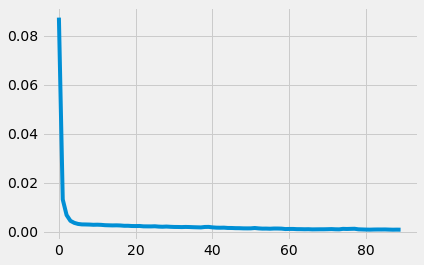

In [24]:
#PLotting loss, it shows that loss has decreased significantly and model trained well
loss = model.history.history['loss']
plt.plot(loss)

In [25]:
#Predicitng on train and test data
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [26]:
#Inverse transform to get actual value
train_predict = normalizer.inverse_transform(train_predict)
test_predict = normalizer.inverse_transform(test_predict)

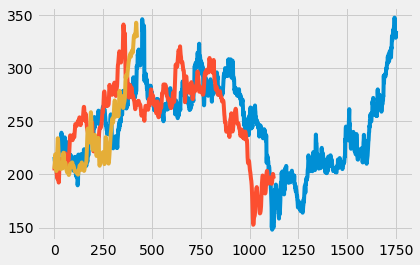

In [27]:
#Comparing using visuals
plt.plot(normalizer.inverse_transform(ds_scaled),label= 'Scaled Value')
plt.plot((train_predict),label= 'Training value')
plt.plot((test_predict),label= 'Testing value')

In [28]:
type(train_predict)

numpy.ndarray

In [29]:
test = np.vstack((train_predict,test_predict))

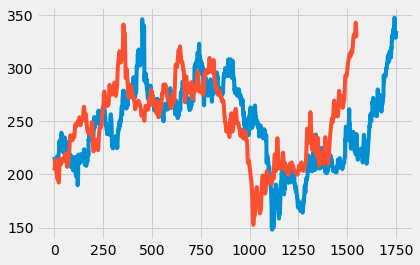

In [30]:
#Combining the predited data to create uniform data visualization
plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(test)

In [31]:
len(ds_test)

526

In [33]:
#Getting the last 100 days records
fut_inp = ds_test[426:]

In [34]:
fut_inp = fut_inp.reshape(1,-1)

In [35]:
tmp_inp = list(fut_inp)

In [36]:
fut_inp.shape

(1, 100)

In [37]:
#Creating list of the last 100 data
tmp_inp = tmp_inp[0].tolist()

In [38]:
#Predicting next 30 days price suing the current data
#It will predict in sliding window manner (algorithm) with stride 1
lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(tmp_inp)>100):
        fut_inp = np.array(tmp_inp[1:])
        fut_inp=fut_inp.reshape(1,-1)
        fut_inp = fut_inp.reshape((1, n_steps, 1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        tmp_inp = tmp_inp[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        fut_inp = fut_inp.reshape((1, n_steps,1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[[0.9087398052215576], [0.9105980396270752], [0.9089416861534119], [0.9056187272071838], [0.9014608263969421], [0.8967350721359253], [0.8915446996688843], [0.8859879374504089], [0.880186140537262], [0.874271035194397], [0.8683692812919617], [0.8625901937484741], [0.8570196032524109], [0.8517166376113892], [0.8467163443565369], [0.8420307040214539], [0.8376544117927551], [0.8335692286491394], [0.8297490477561951], [0.8261641263961792], [0.8227853178977966], [0.8195855617523193], [0.8165434002876282], [0.8136428594589233], [0.8108728528022766], [0.8082283735275269], [0.8057082891464233], [0.8033150434494019], [0.8010522127151489], [0.7989245653152466]]


In [39]:
len(ds_scaled)

1752

In [40]:
#Creating a dummy plane to plot graph one after another
plot_new=np.arange(1,101)
plot_pred=np.arange(101,131)

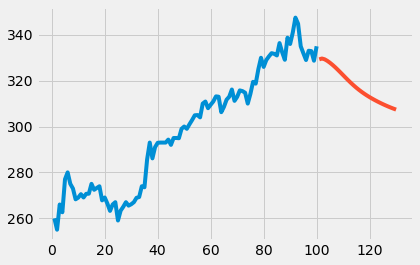

In [41]:
plt.plot(plot_new, normalizer.inverse_transform(ds_scaled[1652:]))
plt.plot(plot_pred, normalizer.inverse_transform(lst_output))

In [42]:
ds_new = ds_scaled.tolist()

In [43]:
len(ds_new)

1752

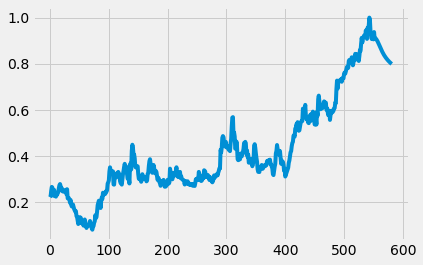

In [44]:
#Entends helps us to fill the missing value with approx value
ds_new.extend(lst_output)
plt.plot(ds_new[1200:])

In [45]:
#Creating final data for plotting
final_graph = normalizer.inverse_transform(ds_new).tolist()

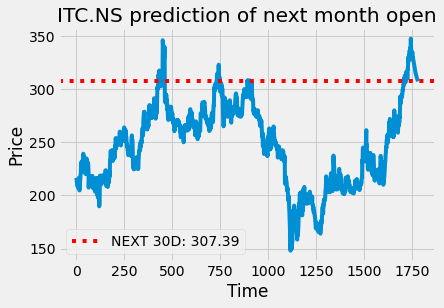

In [46]:
#Plotting final results with predicted value after 30 Days
plt.plot(final_graph,)
plt.ylabel("Price")
plt.xlabel("Time")
plt.title("{0} prediction of next month open".format('ITC.NS'))
plt.axhline(y=final_graph[len(final_graph)-1], color = 'red', linestyle = ':', label = 'NEXT 30D: {0}'.format(round(float(*final_graph[len(final_graph)-1]),2)))
plt.legend()

In [70]:
for i in range(0,len(final_graph)):
    print(final_graph[i])


[216.49999999999997]
[214.99999999999997]
[212.60000610351565]
[212.89999389648438]
[213.3333282470703]
[210.8666687011719]
[208.73333740234372]
[210.1666717529297]
[207.33332824707034]
[209.8000030517578]
[209.1666717529297]
[208.6666717529297]
[212.43333435058594]
[216.6666717529297]
[210.93333435058594]
[210.60000610351562]
[204.6666717529297]
[209.86666870117188]
[215.43333435058594]
[212.6333312988281]
[214.66667175292966]
[218.03334045410156]
[220.0]
[221.33332824707034]
[229.30000305175778]
[231.1666717529297]
[227.26666259765628]
[228.69999694824216]
[226.6666717529297]
[229.46665954589844]
[229.33332824707028]
[232.03334045410156]
[231.99999999999997]
[233.6666717529297]
[232.73333740234375]
[233.39999389648438]
[239.23333740234375]
[236.46665954589844]
[236.23333740234375]
[236.73333740234372]
[234.3000030517578]
[222.0]
[224.5333404541016]
[224.5666656494141]
[222.6666717529297]
[223.76666259765625]
[221.00000000000003]
[227.1999969482422]
[220.26666259765625]
[220.0]
[228.1

In [71]:
writer=pd.ExcelWriter('ITC_Sept.xlsx')

In [72]:
data1=pd.DataFrame({'Predictions':final_graph})

In [73]:
data1.to_excel(writer)

In [74]:
writer.save()